In [3]:
import numpy as np
import configargparse
from utils.auxillary import prepare_data, prepare_data_all
import methods
import cupy as cp
from args import parse

opt = parse('-c configs/exp4.conf')

training_samples, test_validation_samples = prepare_data_all('ytc_py.pkl', opt.mode)
sample = test_validation_samples[8]

if opt.mode == 'test':
    if opt.method == 'msm':
        classifier = methods.MSM(opt.dim_subspace, opt.num_cosines)
    if opt.method == 'msm_mod':
        classifier = methods.MSM_MOD(opt.dim_subspace, opt.num_cosines)
    elif opt.method == 'kmsm':
        classifier = methods.KMSM(opt.dim_subspace, opt.num_cosines, opt.sigma, opt.kernel)
    elif opt.method == 'kmsm_mod':
        classifier = methods.KMSM_MOD(opt.dim_subspace, opt.num_cosines, opt.sigma, opt.kernel, opt.dim_diffspace)
    

classifier.train(training_samples)



gt_label = sample[0]
pred_labels, scores, mod_scores, candidate_imgs = classifier.evalulate_single(sample[1])
highest_label  = pred_labels[cp.asnumpy(cp.argmax(scores))] 

print(f'Correct Label : {gt_label}, Predicted Labels : {highest_label}')
print(f'Top 5 candidates were {np.array(pred_labels, dtype=object)[cp.asnumpy((cp.argsort(scores))[::-1])] }')
print(f'The mod scores {mod_scores}')
print(f'Number of Images for each Train Sets : {[x.shape[1] for x in candidate_imgs]}')
print(f'Number of Images for each Test Set : {[sample[1].shape[1]]}')

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=1)


fig.add_trace(go.Bar(x = pred_labels, y =cp.asnumpy(-1/cp.log(scores)) ), row = 1, col = 1)
fig.show()


Correct Label : sandra_bullock, Predicted Labels : sandra_bullock
Top 5 candidates were ['sandra_bullock' 'elvis_presley' 'hugh_grant' 'gloria_estefan'
 'christian_slater']
The mod scores [0.9409372  0.94512367 0.91051033 0.91401624 0.85713657]
Number of Images for each Train Sets : [273, 412, 487, 226, 539]
Number of Images for each Test Set : [886]


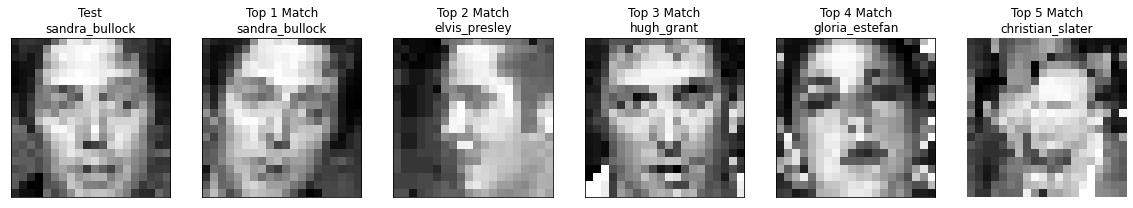

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20), facecolor=(1,1,1))
#plt.style.use("white_background")
axes = []
axes.append(fig.add_subplot(1,6,1))
axes[0].imshow(sample[1][:, 0].reshape(20,20), cmap = 'gray')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].set_title(f'Test\n{gt_label}')

for i in range(1,6):
    axes.append(fig.add_subplot(1,6,i+1))
    axes[i].imshow(cp.asnumpy(candidate_imgs[i-1])[:, 0].reshape(20,20), cmap = 'gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(f'Top {i} Match\n{pred_labels[i-1]}')
plt.axis('off')
plt.show()

In [ ]:
import optuna
import matplotlib.pyplot as plt

expname = 'val_problem2'

loaded_study = optuna.load_study(study_name=expname, storage=f"sqlite:///db/{expname}.db")
	
optuna.visualization.plot_param_importances(loaded_study)